Using TensorFlow backend.


In [8]:
timesteps_max, enc_tokens, x, x_decoder = get_mnist_data(num_samples=60000)

60000


In [9]:
# coding: utf-8

import numpy as np
from nltk.tokenize import word_tokenize
from lstm_vae import create_lstm_vae, inference
from train import get_text_data
import keras
import sys, time
from keras.callbacks import CSVLogger

from tensorflow import set_random_seedPractical Bayesian optimization of machine learning algorithms
set_random_seed(1234)
np.random.seed(1234)

def get_mnist_data(num_samples=1000):
            
    # load data
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
    n_inputs, height, max_length = X_train.shape
    encoder_input_data = np.zeros((n_inputs, max_length + 1, height), dtype="float32")
    decoder_input_data = np.zeros((n_inputs, max_length + 1, height), dtype="float32")
    encoder_input_data[:,:max_length,:] = np.swapaxes(X_train, 1, 2).copy()/255
    decoder_input_data[:,1:,:] = np.swapaxes(X_train, 1, 2).copy()/255

    return max_length + 1, height, encoder_input_data[:num_samples,:,:], decoder_input_data[:num_samples,:,:]

num_samples = 5000
timesteps_max, enc_tokens, x, x_decoder = get_mnist_data(num_samples=num_samples)

print(x.shape, "Creating model...")

input_dim = x.shape[-1]
timesteps = x.shape[-2]
batch_size = 1
latent_dim = 191
intermediate_dim = 353
epochs = 40

vae, enc, gen, stPractical Bayesian optimization of machine learning algorithmsepper = create_lstm_vae(input_dim,
                                         batch_size=batch_size,
                                         intermediate_dim=intermediate_dim,
                                         latent_dim=latent_dim)
print("Training model...")

vae.fit([x, x_decoder], x, epochs=epochs, verbose=1)

print("Saving model ... ")

vae.save("models/vae_mnist_"+str(num_samples)+"_epoch_"+str(epochs)+".h5")
enc.save("models/encoder_mnist_"+str(num_samples)+"_epoch_"+str(epochs)+".h5")
gen.save("models/generator_mnist_"+str(num_samples)+"_epoch_"+str(epochs)+".h5")
stepper.save("models/stepper_mnist_"+str(num_samples)+"_epoch_"+str(epochs)+".h5")

print("Fitted, predicting...")


def decode(s):
    return inference.decode_sequence(s, gen, stepper, input_dim, timesteps_max)


for _ in range(5):

    id_from = np.random.randint(0, x.shape[0] - 1)
    id_to = np.random.randint(0, x.shape[0] - 1)

    m_from, std_from = enc.predict([[x[id_from]]])
    m_to, std_to = enc.predict([[x[id_to]]])

    seq_from = np.random.normal(size=(latent_dim,))
    seq_from = m_from + std_from * seq_from

    seq_to = np.random.normal(size=(latent_dim,))
    seq_to = m_to + std_to * seq_to

    print("== from \t ==")
    plt.imshow(x[id_from].T, cmap='Greys',  interpolation='nearest')
    plt.show()

    for v in np.linspace(0, 1, 7):
        print("%.2f\t" % (1 - v))
        plt.imshow(decode(v * seq_to + (1 - v) * seq_from).T, cmap='Greys',  interpolation='nearest')
        plt.show()

    print("== from \t ==")
    plt.imshow(x[id_to].T, cmap='Greys',  interpolation='nearest')
    plt.show()

(5000, 29, 28) Creating model...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, None, 28)     0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 353)          539384      input_6[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 191)          67614       lstm_3[0][0]                     
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 191)          67614       lstm_3[0][0]                     
____________________________________________________________________________

/Users/mathiastornquist/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:877: UserWarning: Layer lstm_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'dense_7/BiasAdd:0' shape=(?, 353) dtype=float32>, <tf.Tensor 'dense_7/BiasAdd:0' shape=(?, 353) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/Users/mathiastornquist/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:877: UserWarning: Layer lstm_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'dense_7_1/BiasAdd:0' shape=(?, 353) dtype=float32>, <tf.Tensor 'dense_7_1/BiasAdd:0' shape=(?, 353) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/Users/mathiastornquist/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:877: UserWarning: Laye

Fitted, predicting...
== from 	 ==


NameError: name 'plt' is not defined

In [ ]:


def main(params):
    
    num_samples = int(params['num_samples'])
    data_path = "data/" + params['dataset']
    dataname = params['dataset'].split('.')[0]
    
    batch_size = int(params['batch_size'])
    latent_dim = int(params['latent_dim'])
    intermediate_dim = int(params['intermediate_dim'])
    epochs = int(params['epochs'])
    
    train = int(params['train'])
    save = int(params['save'])
    load = int(params['load'])
    
    print_default = int(params['print_default'])
    
   
    timesteps_max, enc_tokens, characters, char2id, id2char, x, x_decoder = get_text_data(num_samples=num_samples,
                                                                                          data_path=data_path)

    
    input_dim = x.shape[-1]
    timesteps = x.shape[-2]

        
    if load:
        print("Loading model ... ")
        
        #vae = keras.models.load_model("models/vae_{}_{}.h5".format(dataname, num_samples))
        enc = keras.models.load_model("models/encoder_{}_{}.h5".format(dataname, num_samples))
        gen = keras.models.load_model("models/generator_{}_{}.h5".format(dataname, num_samples))
        stepper = keras.models.load_model("models/stepper_{}_{}.h5".format(dataname, num_samples))
    
    if train:
        print("Training model...")
        
        vae, enc, gen, stepper = create_lstm_vae(input_dim,
                                             batch_size=batch_size,
                                             intermediate_dim=intermediate_dim,
                                             latent_dim=latent_dim)
        
        csv_logger = CSVLogger('training_vae.log', separator=',', append=False)
        vae.fit([x, x_decoder], x, epochs=epochs, verbose=1, callbacks=[csv_logger])
        
        if save:
            print("Saving model ... ")
            
            vae.save("models/vae_{}_{}.h5".format(dataname, num_samples))
            enc.save("models/encoder_{}_{}.h5".format(dataname, num_samples))
            gen.save("models/generator_{}_{}.h5".format(dataname, num_samples))
            stepper.save("models/stepper_{}_{}.h5".format(dataname, num_samples))

    def decode(s, start_char = "\t"):
        return inference.decode_sequence(s, gen, stepper, input_dim, char2id, id2char, timesteps_max, start_char = start_char)

    def continue_seq(x_start, states_value, h0 = False, sampling = False):
        return inference.continue_sequence(x_start, states_value, h0, sampling, gen, stepper, input_dim, char2id, id2char, timesteps_max)
    
    if print_default:

        for _ in range(6):
            id_from = np.random.randint(0, x.shape[0] - 1)
            id_sentence = np.random.randint(0, x.shape[0] - 1)

            n_words = np.sum(x[id_sentence])
            n_kept = np.random.randint(n_words//2, n_words-1)

            new_x = np.zeros((x[id_sentence].shape))
            new_x[:n_kept,:] = x[id_sentence,:n_kept,:]

            m_new, std_new = enc.predict([[x[id_from]]])
            h_new = np.random.normal(size=(latent_dim,))
            states_new = m_new + std_new * h_new

            print("==  \t", " ".join([id2char[j] for j in np.argmax(new_x[:n_kept], axis=1)]), " ... \t\t ==")

            print("\t...\t", continue_seq(new_x, states_new))
            print("\t...\t", continue_seq(new_x, states_new, h0 = True))

            print("\t...\t", continue_seq(new_x, states_new, sampling = True))
            print("\t...\t", continue_seq(new_x, states_new, h0 = True, sampling = True))


            print("==  \t", " ".join([id2char[j] for j in np.argmax(x[id_sentence], axis=1)]), "==")
            
            
raw_text = webtext.raw(webtext.fileids()[5])
listan = [sentence.replace('\t','').replace('*','').replace('\n','').strip() for sentence in re.split("[.!?]+", raw_text) if len(sentence.split())>3]


params = {}
params['batch_size'] = 1
params['latent_dim'] = 191
params['intermediate_dim'] = 353
params['epochs'] = 60
params['verbose'] = 1
params['num_samples'] = len(listan)
params['data_type'] = "text"
params['dataset'] = webtext.fileids()[5] #'wine.txt'
params['train'] = 1
params['save'] = 1
params['load'] = 0
params['print_default'] = 1

main(params)

# Loads the wine model

In [12]:
enc = keras.models.load_model("models/encoder_mnist_600000_samples_epochs_60.h5")
gen = keras.models.load_model("models/generator_mnist_600000_samples_epochs_60.h5")
stepper = keras.models.load_model("models/stepper_mnist_600000_samples_epochs_60.h5")

/Users/mathiastornquist/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


== from 	 ==


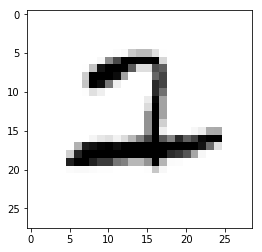

1.00	


NameError: name 'char2id' is not defined

In [19]:
import matplotlib.pyplot as plt

def decode(s, start_char = "\t"):
        return inference.decode_sequence(s, gen, stepper, input_dim, timesteps_max, char2id, id2char, start_char = start_char, data_type = data_type)


print("== from \t ==")
plt.imshow(x[id_from].T, cmap='Greys',  interpolation='nearest')
plt.grid(False)
plt.show()

for v in np.linspace(0, 1, 7):
    print("%.2f\t" % (1 - v))
    plt.imshow(decode(v * seq_to + (1 - v) * seq_from).T, cmap='Greys',  interpolation='nearest')
    plt.grid(False)
    plt.show()

print("== to \t ==")
plt.imshow(x[id_to].T, cmap='Greys',  interpolation='nearest')
plt.grid(False)
plt.show()